# Simple close loop simulation (past version)

## HouseKeeping

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from acados_template import AcadosModel, AcadosSim, AcadosSimSolver
import casadi as cs
import pinocchio as pin
from pinocchio import casadi as cpin
import example_robot_data as robex

working_path = os.getcwd()
print(working_path)

/home/anran.zhang/code/test_robot_models


In [2]:
# Functions related to visualization
def plot_states(q, q_dot,torque,t):
    n_col = 3
    N_sim = q.shape[1]
    nq = q.shape[0]

    fig, axes = plt.subplots(nrows=nq, ncols=n_col, figsize=(8, 8))
    fig.tight_layout()

    for i in range(nq):
        plt.subplot(nq, n_col, i * n_col + 1)
        line, = plt.plot(t,q[i, :])
        plt.xlabel('$t$')
        plt.ylabel(f"q[{i}]")
        plt.grid()

    for i in range(nq):
        plt.subplot(nq, n_col, i * n_col + 2)
        line, = plt.plot(t,q_dot[i, :])
        plt.xlabel('$t$')
        plt.ylabel(f"q_dot[{i}]")
        plt.grid()

    t1 = np.concatenate((np.zeros((torque.shape[0],1)), torque),axis=1) # added one col to u
    for i in range(nq):
        plt.subplot(nq, n_col, i * n_col + 3)
        line, = plt.plot(t,t1[i, :])
        plt.xlabel('$t$')
        plt.ylabel(f"torque[{i}]")
        plt.grid()

    plt.tight_layout()
    plt.show()

## Ur10

In [3]:
def load_robot(name):
    return robex.load(name)

In [4]:
def create_acados_model(robot) -> AcadosModel:
    name = 'ur5'
    model = robot.model
    print(model)

    cmodel = cpin.Model(model)
    cdata = cmodel.createData()

    q = cs.SX.sym("q", model.nq)
    q_dot = cs.SX.sym("q_dot", model.nv)
    x = cs.vertcat(q, q_dot) # states
 
    tau = cs.SX.sym("tau", model.nv) # toqures(input)
    
    q_dot_ = cs.SX.sym("q_dot_", model.nq)
    q_ddot_ = cs.SX.sym("q_ddot_", model.nv)
    x_dot = cs.vertcat(q_dot_, q_ddot_)

    # f_expl = (q_dot, q_ddot) = x_dot
    f_expl = cs.vertcat(q_dot, cpin.aba(cmodel, cdata, q, q_dot, tau)) 
    
    f_impl = x_dot - f_expl  # Implicit dynamics, representing the time derivative of the state minus the explicit dynamics.

    model = AcadosModel()
    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = x 
    model.xdot = x_dot
    model.u = tau
    model.name = name

    return model

In [5]:
ur5 = load_robot('ur5') # pinocchio model
pin_model = ur5.model
pin_data = ur5.data

# acados model
acados_model = create_acados_model(ur5) 


Nb joints = 7 (nq=6,nv=6)
  Joint 0 universe: parent=0
  Joint 1 shoulder_pan_joint: parent=0
  Joint 2 shoulder_lift_joint: parent=1
  Joint 3 elbow_joint: parent=2
  Joint 4 wrist_1_joint: parent=3
  Joint 5 wrist_2_joint: parent=4
  Joint 6 wrist_3_joint: parent=5



In [6]:
def fake_traj(start, end,length=1000):
    diff = (np.array(end)- np.array(start))/length
    traj = np.zeros((12, length + 1))
    traj[:, 0] = start
    for i in range(length):
        traj[:,i+1] = traj[:, i] + diff 
    return traj

In [8]:
class PID_controller:
    # Defining the P,I,D control parameters
    def __init__(self, model,data, kp=[100,160,80,100,100,100],ki=[0,0,0,0,0,0],  kd=[0.00,0.00,0.00,0.000,0.000,0.000],torque_limit =400, i_max = 10, i_min = -10):
        self.model = model
        self.data = data
        self.nu = self.model.nv
        # self.dt = dt
        self.kp = np.array(kp)
        # self.kd = np.array([2*np.sqrt(ele) for ele in self.kp])
        self.kd = np.array(kd)
        self.ki = np.array(ki)
        self.error_p = []
        self.error_p_last = np.zeros(self.kp.shape)
        self.error_i = np.array([0.]*self.nu)
        self.speed = 1
        self.i_max = i_max
        self.i_min = i_min
        self.torque_limit = torque_limit
        self.g = []
        self.M = []
        self.torque = []
        # kp=[150,200,150,150,50,50],ki=[0,0,0,0,0,0], kd=[0.05,0.05,0.05,0.01,0.01,0.01] # reference trajectory
        # kp=[3,12,12,6,6,6],ki=[0,0,0,0,0,0], kd=[0.001,0.001,0.001,0.0003,0.0003,0.0003] # set point
    
    # update dynamic  parameters
    def calculate_g_once(self,q):
        return pin.computeGeneralizedGravity(self.model,self.data, q) 
    def calculuate_M_once(self,q):
        return pin.crba(self.model, self.data, q)
    
    def update_dynamics_parameters(self,robot_state):
        print(robot_state[:self.nu])
        self.g = self.calculate_g_once(robot_state[:self.nu])
        self.M = self.calculuate_M_once(robot_state[:self.nu])
        # pin.computeAllTerms(self.model,self.data,robot_state[:self.nu],robot_state[self.nu:])
        # pin.updateFramePlacements(self.model,self.data)

    def print_control_gain(self):
        print("currently using control gain: ")
        print('------------------------------------------------')
        print(f'kp: {self.kp}\n ki: {self.ki}\n kd: {self.kd}\n')

    def set_control_gain(self, gain):
        self.kp = gain["kp"]
        self.ki = gain["ki"]
        self.kd = gain["kd"]
        print("PID control gain set manually")
        self.print_control_gain()


    def clear_error_i(self):
        self.error_i = np.array([0.00]*self.nu)
        print("integration error erased!")

    def calc_error(self,robot_state,reference,dt):
        self.error_p = (np.array(reference) - np.array(robot_state))[:self.nu]
        self.error_i += self.error_p*dt 
        self.error_i = np.clip(self.error_i, -100,100)
        self.error_d = (self.error_p - self.error_p_last)/dt
        self.error_p_last = self.error_p
    
    def compute_torque(self,robot_state,reference,dt=1e-3):
        self.calc_error(robot_state,reference,dt)
        # self.update_dynamics_parameters(robot_state)
        kp_term = np.array(self.kp)*np.array(self.error_p) 
        kd_term = np.array(self.kd)*np.array(self.error_d)
        ki_term = np.array(self.ki)*np.array(self.error_i)
        # print(f'kp_term: {kp_term}\n')
        # print(f'ki_term: {ki_term}\n')
        # print(f'kd_term: {kd_term}\n')
        # self.g = self.calculate_g_once(robot_state[:self.nu])
        # self.torque = kp_term + kd_term + ki_term + self.g
        self.torque = kp_term + kd_term + ki_term 
        # print(np.clip(torque, -self.torque_limit,self.torque_limit))
        return np.clip(self.torque, -self.torque_limit,self.torque_limit)

In [9]:
pid_controller = PID_controller(pin_model,pin_data) 

In [12]:
def sim(model, integrator_type, n_steps, n_stages,follow_traj=False, collocation_type=[], controller=pid_controller):

    import math
    T_sim = 5 # simulation horizon in seconds
    base_stepsize = 1e-3# timestep = base_stepsize/n_steps
    N_sim = T_sim/base_stepsize # number of simulation, simulation time = N_sim * base_stepsize
    N_sim = math.floor(N_sim)
    
    nx = model.x.size()[0]
    nu = model.u.size()[0]

    x0 = np.zeros((nx, )) 
    xd = np.array([1.0]*6 + [0.0]*6)
    dt = base_stepsize/n_steps

    if follow_traj:
        reference_traj = fake_traj([0.0]*12,[1.0]*6 + [0.0]*6,N_sim)
 
    sim = AcadosSim()
    sim.model = model
    sim.solver_options.T = base_stepsize    
    sim.solver_options.integrator_type = integrator_type
    sim.solver_options.num_stages = n_stages
    sim.solver_options.num_steps = n_steps
    sim.solver_options.newton_iter = 3 # For implicit intgrators
    sim.solver_options.sens_forw = False # Generate forward sensitivities
    
    if integrator_type == 'IRK':
        sim.solver_options.collocation_type = collocation_type
    
    if integrator_type == 'IRK_GNSF':
        sim.solver_options.set('gnsf_detect_struct', 'true');
    
    int = AcadosSimSolver(sim)

    # Simulate system
    x_sim = np.zeros((nx, N_sim + 1))
    x_sim[:, 0] = x0
    u_sim = np.zeros((nu, N_sim))
    for ii in range(N_sim):        
        # Set initial state
        int.set('x', x_sim[:, ii])
        if follow_traj:
            u = controller.compute_torque(x_sim[:,ii],reference_traj[:,ii],dt)
            int.set('u',u)
        else:
            if (ii<3000):
                u = controller.compute_torque(x_sim[:,ii],x0,dt)
            else:
                u = controller.compute_torque(x_sim[:,ii],xd,dt) # new pose
            int.set('u',u)

        u_sim[:, ii ] = u
        
        if integrator_type == 'IRK':
            int.set('xdot', np.zeros((nx, )))
        elif integrator_type == 'IRK_GNSF':
            n_out = sim.model_struct.dim_gnsf_nout;
            sim.set('phi_guess', np.zeros((n_out, )))
        
        int.solve()
        x_sim[:, ii + 1] = int.get('x')
    return x_sim,u_sim

In [11]:
control_gain = {
    # "kp":[6,81,51,81,90,20],
    # "ki":[0,0,0,0,0,0],
    # # "kd":[0.000,0.00000,0.0,0.0,0.0,0.0]
    # "kd":[0.0013,0.00000000000,0.05,0.15,0.02,0.02]
    "kp":[85]*3 + [10]*3,
    "ki":[100]*3 + [10,10,3],
    "kd":[30]*3 + [1,1,0.1],
}
pid_controller.set_control_gain(control_gain)

PID control gain set manually
currently using control gain: 
------------------------------------------------
kp: [85, 85, 85, 10, 10, 10]
 ki: [100, 100, 100, 10, 10, 3]
 kd: [30, 30, 30, 1, 1, 0.1]



In [15]:
integrator_type = 'ERK'
collocation_type = 'GAUSS_LEGENDRE'
n_stages = 3 
# n_steps = 3 
n_steps = 1
pid_controller.clear_error_i()
follow_trajectory = False
s_ref,u_ref = sim(acados_model, integrator_type, n_steps, n_stages, follow_trajectory,collocation_type,pid_controller) 

integration error erased!
cc -fPIC -std=c99   -O2 -I/home/anran.zhang/code/test_robot_models/acados/include -I/home/anran.zhang/code/test_robot_models/acados/include/acados -I/home/anran.zhang/code/test_robot_models/acados/include/blasfeo/include -I/home/anran.zhang/code/test_robot_models/acados/include/hpipm/include  -c -o acados_sim_solver_ur5.o acados_sim_solver_ur5.c
cc -fPIC -std=c99   -O2 -I/home/anran.zhang/code/test_robot_models/acados/include -I/home/anran.zhang/code/test_robot_models/acados/include/acados -I/home/anran.zhang/code/test_robot_models/acados/include/blasfeo/include -I/home/anran.zhang/code/test_robot_models/acados/include/hpipm/include  -c -o ur5_model/ur5_expl_ode_fun.o ur5_model/ur5_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/anran.zhang/code/test_robot_models/acados/include -I/home/anran.zhang/code/test_robot_models/acados/include/acados -I/home/anran.zhang/code/test_robot_models/acados/include/blasfeo/include -I/home/anran.zhang/code/test_robot_models/acad

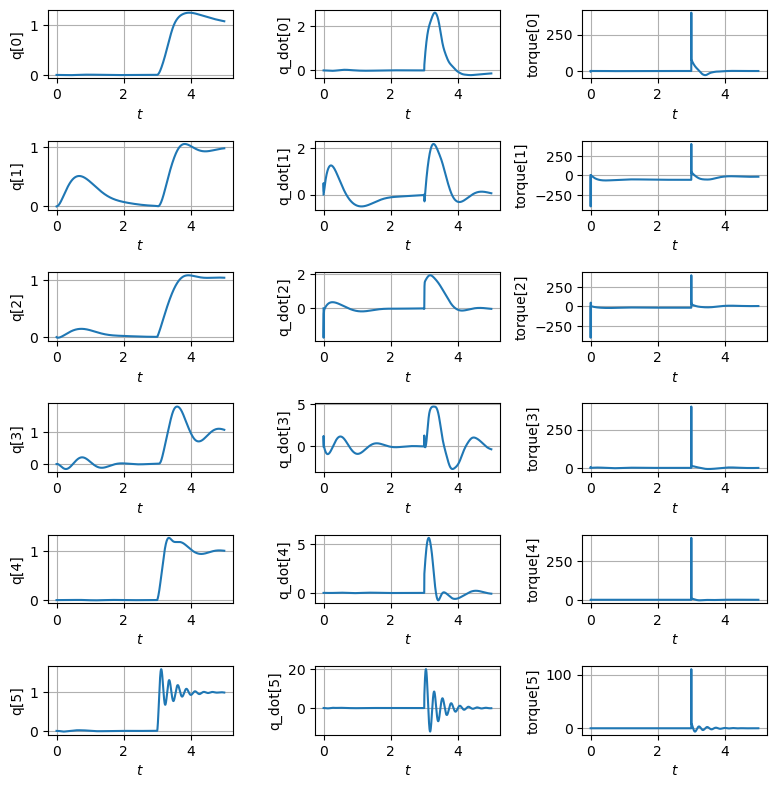

In [16]:
t = [ 1e-3*elem for elem in range(0,5001)]
# t = [ 1e-3*elem for elem in range(0,501)]
plot_states(s_ref[:6, :], s_ref[6:, :],u_ref[:6,:],t)
# print(s_ref)